In [1]:
%matplotlib inline
from copy import deepcopy as copy
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from replay import smln, analysis, plot

cc = np.concatenate


# model
M_PARAMS = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 3000,
    'W_PC_PC': .026, 'L_PC_PC': 0.053, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.005, 'E_L_INH': -0.06, 'V_TH_INH': -0.05, 'V_R_INH': -0.06, 'T_R_INH': 0.002,
    
    # Inh. architecture
    'N_INH': 300,  # unused
    'W_INH_PC': 0.003, 'W_PC_INH': 0.0002,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 125, 
    
    # potentiation
    'SGM_MAX': 2, 'B_SGM': 1, 'R_SGM': 10
}

# simulation
S_PARAMS = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)],
    
    'TRG': [
        {'T': 0.5, 'A': 0.00, 'R': 0.3, 'D': 0.002, 'X': 1, 'Y': -0.75},
    ],
    
    "schedule": {"D_SMLN": 3},
}

# ANALYSIS
A_PARAMS = {
    'MIN_START': 0.25,  # s
    'SMOOTH_FR': 4,  # 2 ms
    'MIN_GAP_DUR': .01,  # s
    'MIN_EVT_DUR': .03,  # s
    'EVT_DTCN_TH': 0.5,  # Hz
    'SPD_CALC_TRNC_FRAC': 0.1,  # fraction
    'POS_T_CORR_TH': 0.85,  # correlation
    'MIN_DUR_SPD_CALC': 0.05,  # s
}

## Test replay speed calculation

Running smln...
Smln complete.


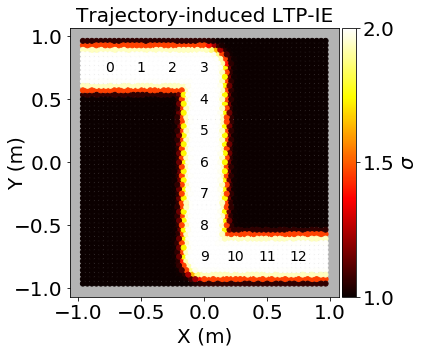

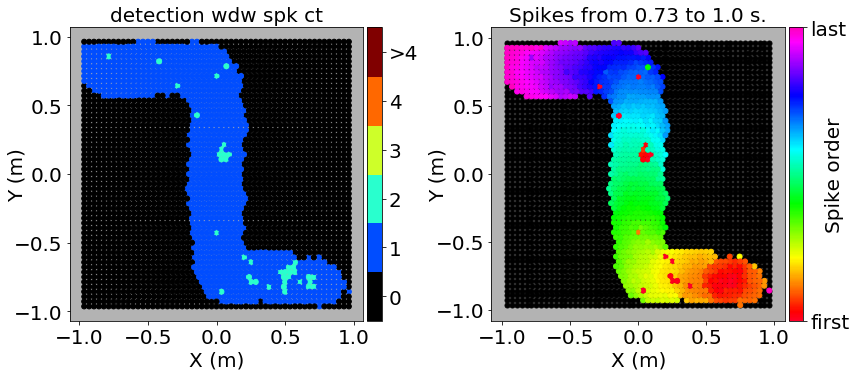

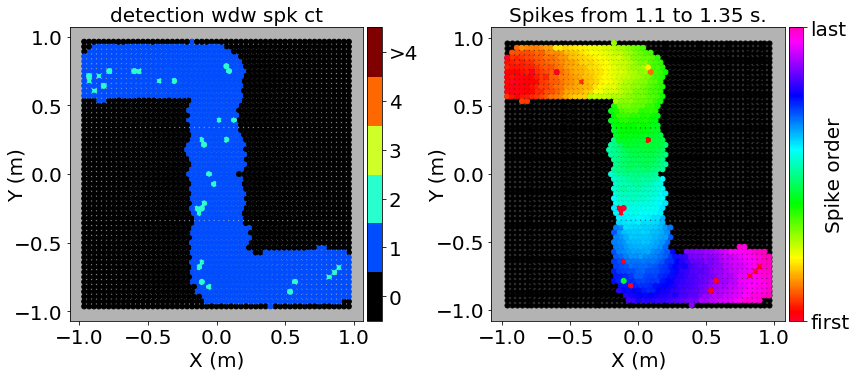

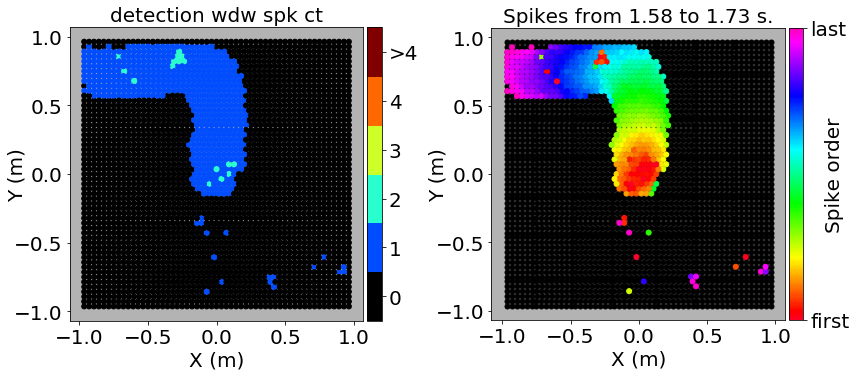

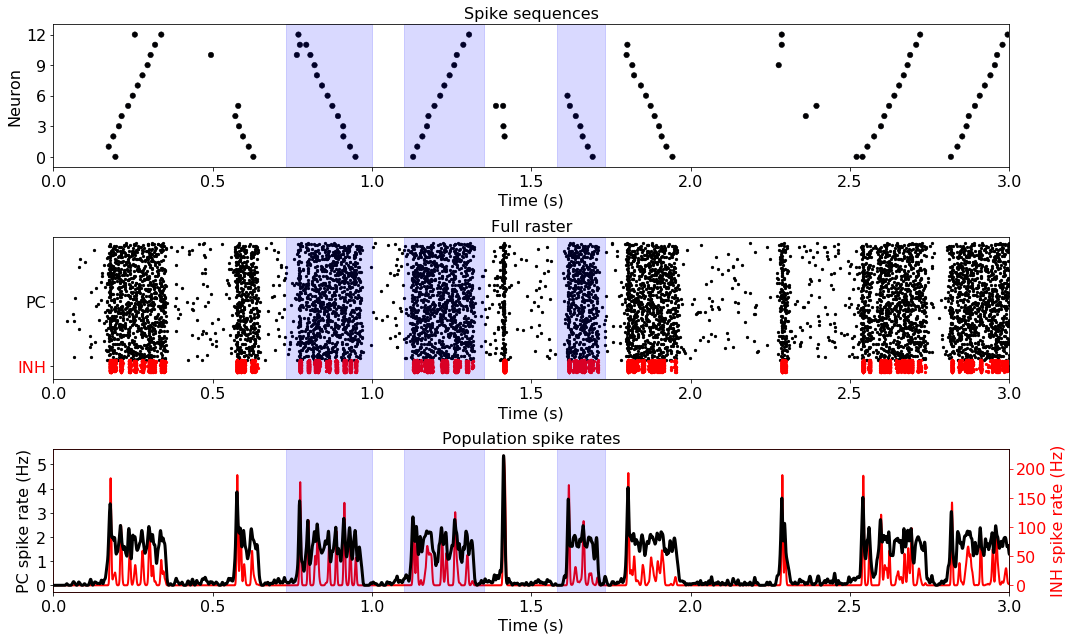

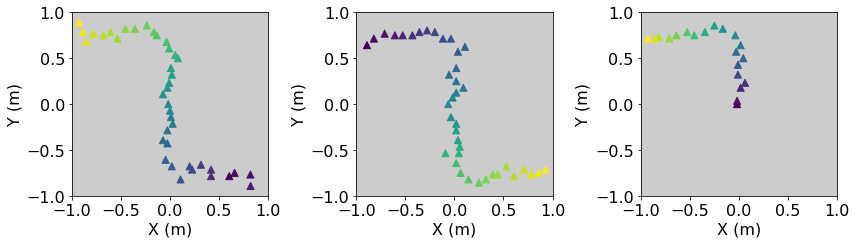

In [2]:
# run smln
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['RNG_SEED'] = 12

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

# make plots
XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]
EPOCHS = [(.73, 1.), (1.1, 1.35), (1.58, 1.73)]

## potentiation profile
ax, c_ax = plot.ltp_ie_profile(rslt)

## add PC labels
for ctr, (x, y) in enumerate(XYS_RASTER):
    ax.text(x, y, str(ctr), fontsize=14, horizontalalignment='center', verticalalignment='center')

## selected replay epoch spike sequences
for epoch in EPOCHS:
    fig, axs = plot.spike_seq(rslt, epoch=epoch)

## raster for selected PCs
fig, axs = plot.raster_with_pc_inh(
    rslt,
    XYS_RASTER,
    colors=np.zeros(len(XYS_RASTER)),
    cmap='inferno',
    nearest=1,
    epoch=(0, 3),
    trg_plt=[],
    y_lim=(-1, 13),
    y_ticks=[0, 3, 6, 9, 12],
    smoothness=4)

## shade selected replay epochs
for epoch in EPOCHS:
    axs[0].axvspan(*epoch, color='b', alpha=0.15)
    axs[1].axvspan(*epoch, color='b', alpha=0.15)
    axs[2].axvspan(*epoch, color='b', alpha=0.15)
    
## plot decoded trajectories during replay epochs
axs = plt.subplots(1, len(EPOCHS), figsize=(len(EPOCHS)*4, 3.5), tight_layout=True, squeeze=False)[1][0]
for epoch, ax in zip(EPOCHS, axs):
    t, xy = analysis.decode_trj(rslt, epoch[0], epoch[1], .005, min_spks_wdw=10)
    plot.decoded_trj(ax, rslt, t, xy);

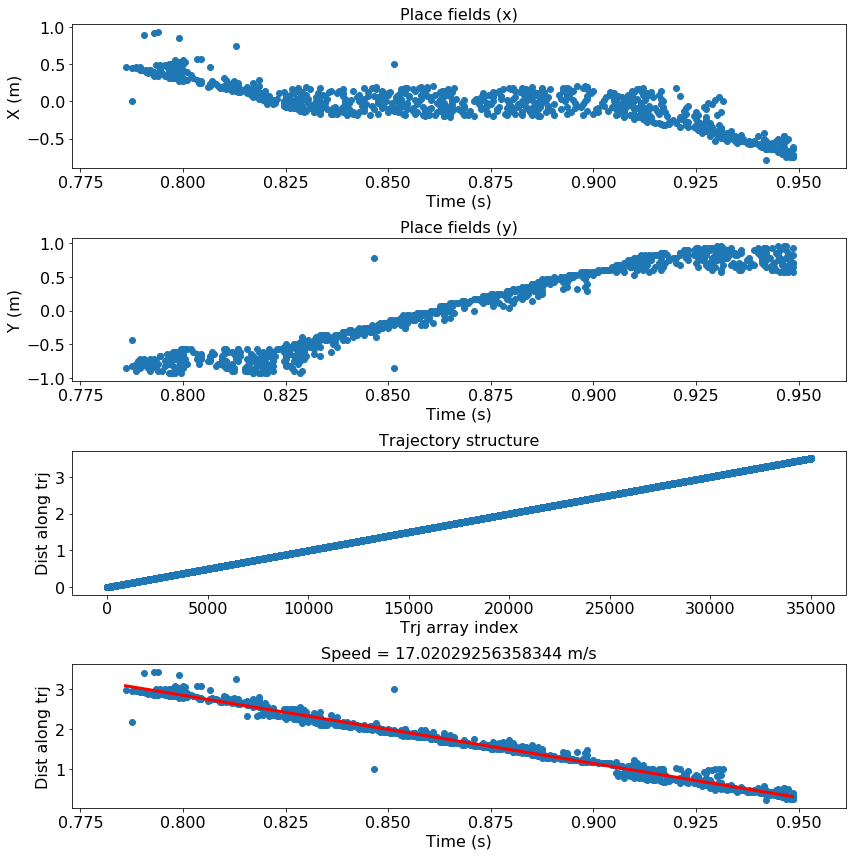

In [3]:
# test spd calc
starts, ends = analysis.get_evts(rslt, A_PARAMS)

start = starts[1]
end = ends[1]

spd, debug = analysis.calc_spd(rslt, start, end, A_PARAMS, debug=True)
pfxs_spk = debug['pfxs_spk']
pfys_spk = debug['pfys_spk']
ds_trj_spk = debug['ds_trj_spk']
ts_spk = debug['ts_spk']

slp = debug['slp']
icpt = debug['icpt']

# plot xs and ys vs spike time
fig, axs = plt.subplots(4, 1, figsize=(12, 12), tight_layout=True)
axs[0].scatter(ts_spk, pfxs_spk)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('X (m)')
axs[0].set_title('Place fields (x)')

axs[1].scatter(ts_spk, pfys_spk)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Y (m)')
axs[1].set_title('Place fields (y)')

axs[2].scatter(np.arange(len(debug['d_trj'])), debug['d_trj'])
axs[2].set_xlabel('Trj array index')
axs[2].set_ylabel('Dist along trj')
axs[2].set_title('Trajectory structure')

# scatter
axs[3].scatter(ts_spk, ds_trj_spk)
# line
x_line = np.array([ts_spk[0], ts_spk[-1]])
y_line = slp*x_line + icpt
axs[3].plot(x_line, y_line, c='r', lw=3)

axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Dist along trj')
axs[3].set_title('Speed = {} m/s'.format(spd))

for ax in axs:
    set_font_size(ax, 16)

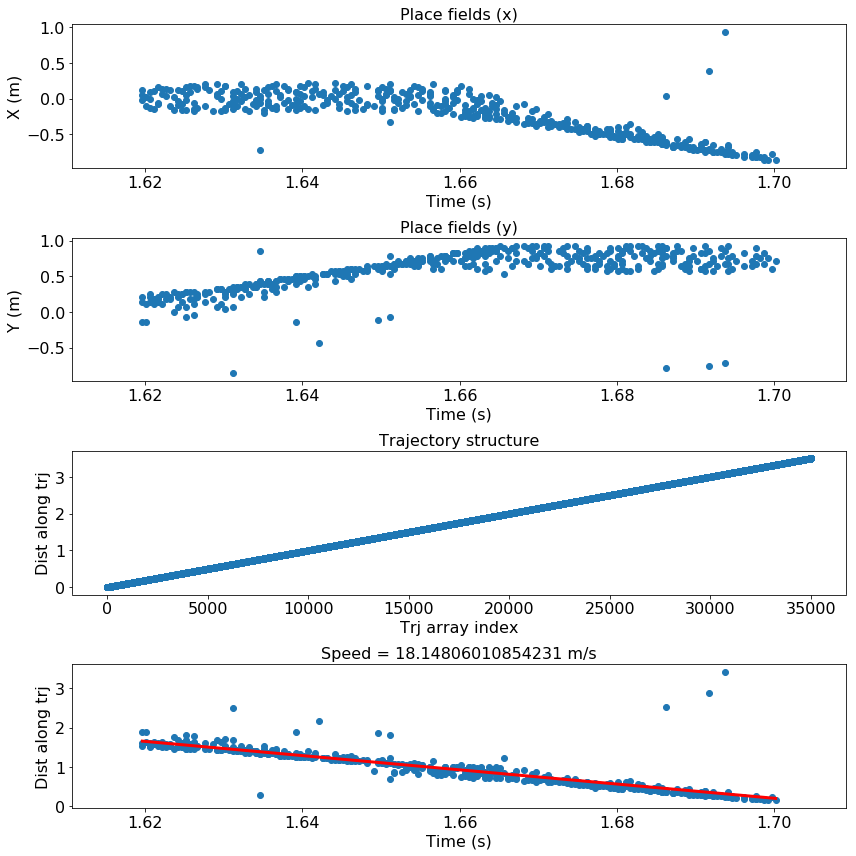

In [4]:
# test spd calc
start = starts[3]
end = ends[3]

spd, debug = analysis.calc_spd(rslt, start, end, A_PARAMS, debug=True)
pfxs_spk = debug['pfxs_spk']
pfys_spk = debug['pfys_spk']
ds_trj_spk = debug['ds_trj_spk']
ts_spk = debug['ts_spk']

slp = debug['slp']
icpt = debug['icpt']

# plot xs and ys vs spike time
fig, axs = plt.subplots(4, 1, figsize=(12, 12), tight_layout=True)
axs[0].scatter(ts_spk, pfxs_spk)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('X (m)')
axs[0].set_title('Place fields (x)')

axs[1].scatter(ts_spk, pfys_spk)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Y (m)')
axs[1].set_title('Place fields (y)')

axs[2].scatter(np.arange(len(debug['d_trj'])), debug['d_trj'])
axs[2].set_xlabel('Trj array index')
axs[2].set_ylabel('Dist along trj')
axs[2].set_title('Trajectory structure')

# scatter
axs[3].scatter(ts_spk, ds_trj_spk)
# line
x_line = np.array([ts_spk[0], ts_spk[-1]])
y_line = slp*x_line + icpt
axs[3].plot(x_line, y_line, c='r', lw=3)

axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Dist along trj')
axs[3].set_title('Speed = {} m/s'.format(spd))

for ax in axs:
    set_font_size(ax, 16)